# Train Action-Chunking-Transformer (ACT) on your Dataset
Train the ACT model on your custom dataset. In this example, we set chunk_size as 10. 

In [1]:
import torch

from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.common.policies.act.configuration_act import ACTConfig
from lerobot.common.policies.act.modeling_act import ACTPolicy
from lerobot.configs.types import FeatureType
from lerobot.common.datasets.factory import resolve_delta_timestamps
import torchvision

In [2]:
device = torch.device("cuda:0")

# Number of offline training steps (we'll only do offline training for this example.)
# Adjust as you prefer. 5000 steps are needed to get something worth evaluating.
training_steps = 3000
log_freq = 100

## Policy Configuration and Initialize

chunk_size = 10

In [3]:
# When starting from scratch (i.e. not from a pretrained policy), we need to specify 2 things before
# creating the policy:
#   - input/output shapes: to properly size the policy
#   - dataset stats: for normalization and denormalization of input/outputs
dataset_metadata = LeRobotDatasetMetadata("omy_pnp", root='./demo_data')
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}
# input_features.pop("observation.wrist_image")
# Policies are initialized with a configuration class, in this case `DiffusionConfig`. For this example,
# we'll just use the defaults and so no arguments other than input/output features need to be passed.
cfg = ACTConfig(input_features=input_features, output_features=output_features, chunk_size= 10, n_action_steps=10)
# This allows us to construct the data with action chunking
delta_timestamps = resolve_delta_timestamps(cfg, dataset_metadata)
# We can now instantiate our policy with this config and the dataset stats.
policy = ACTPolicy(cfg, dataset_stats=dataset_metadata.stats)
policy.train()
policy.to(device)

ACTPolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_image): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
    (buffer_observation_state): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
    )
  )
  (normalize_targets): Normalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
    )
  )
  (unnormalize_outputs): Unnormalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
    )
  )
  (model): ACT(
    (v

## Load Dataset

In [5]:
from torchvision import transforms

class AddGaussianNoise(object):
    """
    Adds Gaussian noise to a tensor.
    """
    def __init__(self, mean=0., std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Adds noise: tensor remains a tensor.
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

# Create a transformation pipeline that converts a PIL image to a tensor, then adds noise.
transform = transforms.Compose([
    AddGaussianNoise(mean=0., std=0.02),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])


In [6]:
# We can then instantiate the dataset with these delta_timestamps configuration.
dataset = LeRobotDataset("omy_pnp", delta_timestamps=delta_timestamps, root='./demo_data', image_transforms=transform)

# Then we create our optimizer and dataloader for offline training.
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=64,
    shuffle=True,
    pin_memory=device.type != "cpu",
    drop_last=True,
)


Generating train split: 0 examples [00:00, ? examples/s]

## Train

The trained checkpoint will be saved in './ckpt/act_y' folder.

In [7]:
# Run training loop.
step = 0
done = False
while not done:
    for batch in dataloader:
        inp_batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        loss, _ = policy.forward(inp_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % log_freq == 0:
            print(f"step: {step} loss: {loss.item():.3f}")
        step += 1
        if step >= training_steps:
            done = True
            break


step: 0 loss: 94.380
step: 100 loss: 2.316
step: 200 loss: 1.622
step: 300 loss: 1.295
step: 400 loss: 0.941
step: 500 loss: 0.686
step: 600 loss: 0.526
step: 700 loss: 0.418
step: 800 loss: 0.362
step: 900 loss: 0.296
step: 1000 loss: 0.253
step: 1100 loss: 0.253
step: 1200 loss: 0.212
step: 1300 loss: 0.200
step: 1400 loss: 0.193
step: 1500 loss: 0.174
step: 1600 loss: 0.172
step: 1700 loss: 0.164
step: 1800 loss: 0.152
step: 1900 loss: 0.147
step: 2000 loss: 0.133
step: 2100 loss: 0.129
step: 2200 loss: 0.117
step: 2300 loss: 0.123
step: 2400 loss: 0.113
step: 2500 loss: 0.112
step: 2600 loss: 0.100
step: 2700 loss: 0.101
step: 2800 loss: 0.094
step: 2900 loss: 0.096


In [8]:
# Save the policy to disk.
policy.save_pretrained('./ckpt/act_y')

## Test Inference

To evaluate the policy on the dataset, you can calculate the error between ground-truth actions from the dataset.

In [9]:
import torch

class EpisodeSampler(torch.utils.data.Sampler):
    def __init__(self, dataset: LeRobotDataset, episode_index: int):
        from_idx = dataset.episode_data_index["from"][episode_index].item()
        to_idx = dataset.episode_data_index["to"][episode_index].item()
        self.frame_ids = range(from_idx, to_idx)

    def __iter__(self):
        return iter(self.frame_ids)

    def __len__(self) -> int:
        return len(self.frame_ids)

In [10]:
policy.eval()
actions = []
gt_actions = []
images = []
episode_index = 0
episode_sampler = EpisodeSampler(dataset, episode_index)
test_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    shuffle=False,
    pin_memory=device.type != "cpu",
    sampler=episode_sampler,
)
policy.reset()
for batch in test_dataloader:
    inp_batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
    action = policy.select_action(inp_batch)
    actions.append(action)
    gt_actions.append(inp_batch["action"][:,0,:])
    images.append(inp_batch["observation.image"])
actions = torch.cat(actions, dim=0)
gt_actions = torch.cat(gt_actions, dim=0)
print(f"Mean action error: {torch.mean(torch.abs(actions - gt_actions)).item():.3f}")

Mean action error: 0.014


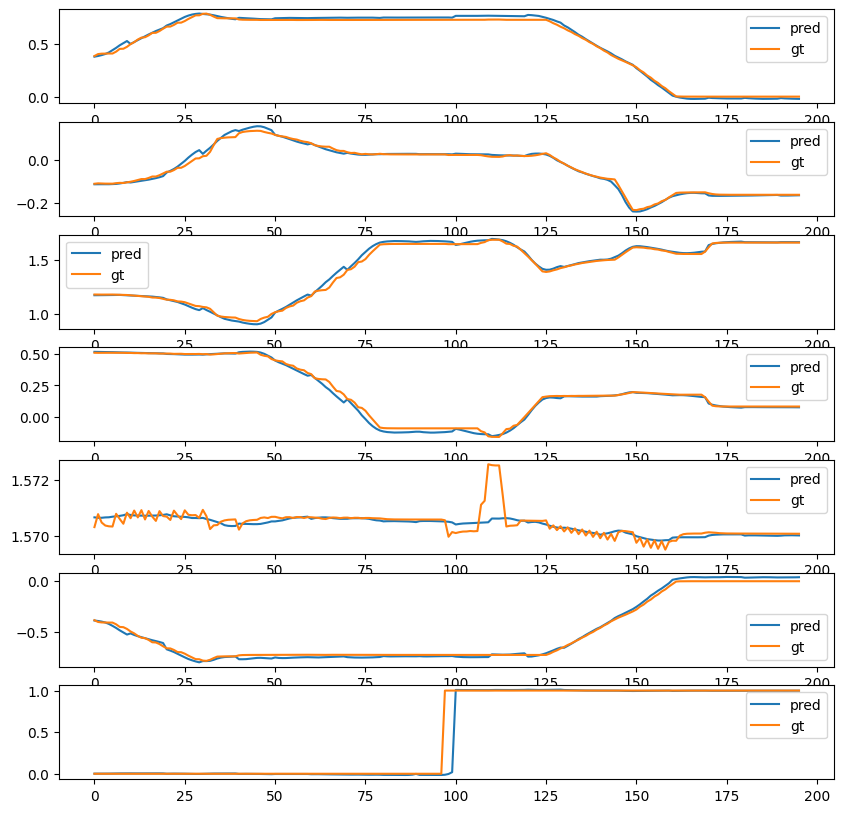

In [11]:
'''
plot actions and gt_actions
'''
import matplotlib.pyplot as plt
action_dim = 7

fig, axs = plt.subplots(action_dim, 1, figsize=(10, 10))

for i in range(action_dim):
    axs[i].plot(actions[:, i].cpu().detach().numpy(), label="pred")
    axs[i].plot(gt_actions[:, i].cpu().detach().numpy(), label="gt")
    axs[i].legend()
plt.show()